# Progetto Corò Elia

In [27]:
# import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.semi_supervised import LabelPropagation
from utils.print_correlation_matrix import PrintCorrelationMatrix

from cleaning.fill_missing_values import fill_missing_values
from cleaning.remove_high_missing_fields import remove_high_missing_fields
from cleaning.remove_high_missing_columns import remove_high_missing_columns
from cleaning.one_hot_encoder import OneHotEncoderFunction


## Data Initial Cleaning

In [28]:
# Carica i dati
data = pd.read_csv('train.csv')

# Mantieni solo le colonne presenti nel set di test
# Questa operazione potrebbe rimuovere colonne se 'train.csv' ha colonne extra
test_columns = list(pd.read_csv('test.csv').columns) + ['sii']
data = data[test_columns]

# Rimuovi la colonna 'id'
data = data.drop(columns=['id'])

# Rimuovi tutte le colonne season
df_cleaned = data.drop(columns=[col for col in data.columns if 'Season' in col])

# Rimuovi colonne con più dell'80% di valori mancanti
data, removed_columns = remove_high_missing_columns(data, threshold=0.80)
print(f"Colonne rimosse: {len(removed_columns)}")

# Separa le righe con 'sii' mancante senza rimuoverle
data_with_sii = data[data['sii'].notna()]
data_without_sii = data[data['sii'].isna()]

# Rimuovi righe con più dell'80% di valori mancanti nel sottoinsieme con 'sii' valido
clean_data, removed_rows = remove_high_missing_fields(data_with_sii, threshold=0.8)
print(f"Righe rimosse: {len(removed_rows)}")

# Ricombina i dati
data = pd.concat([clean_data, data_without_sii], ignore_index=True)

# Controlla i valori mancanti in 'sii'
missing_sii_count = data['sii'].isnull().sum()
print(f"Numero di righe con 'sii' null: {missing_sii_count}")


Colonne rimosse: 5
Righe rimosse: 26
Numero di righe con 'sii' null: 1224


In [29]:
def standardize_dataframe(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_columns = [col for col in numeric_columns if col != 'sii']

    # Mantieni i valori originali di 'sii'
    sii_original = df['sii'].copy()

    scaler = StandardScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

    # Ripristina i valori nulli di 'sii'
    df['sii'] = sii_original

    return df


data = standardize_dataframe(data)
data

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,Fall,-1.521997,-0.770297,Winter,-0.647424,Fall,-0.480065,-1.331104,-0.858103,NaN,...,-0.176702,-0.164755,NaN,NaN,NaN,NaN,NaN,Fall,1.770463,2.0
1,Summer,-0.399790,-0.770297,NaN,NaN,Fall,-1.035839,-1.063457,-0.965819,-0.948658,...,-0.225858,-0.208332,Fall,-0.318421,Fall,0.467724,0.469427,Summer,-0.969017,0.0
2,Summer,-0.119238,1.298200,Fall,0.247605,Fall,-0.524777,0.074043,-0.301573,NaN,...,NaN,NaN,Summer,-0.535339,Fall,-0.299185,-0.287760,Summer,0.857303,0.0
3,Winter,-0.399790,-0.770297,Fall,0.247605,Summer,-0.203318,0.007131,-0.166928,NaN,...,-0.094130,-0.061874,Winter,-0.176787,Summer,-0.970231,-0.969229,Winter,-0.969017,1.0
4,Spring,0.722417,1.298200,Winter,-0.692175,Summer,0.576564,0.475513,0.519759,NaN,...,0.011793,0.070577,Spring,1.940070,Summer,-0.107458,-0.136323,Spring,-0.969017,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3929,Spring,0.722417,-0.770297,Summer,NaN,Summer,NaN,NaN,NaN,NaN,...,NaN,NaN,Summer,-0.905374,NaN,NaN,NaN,NaN,NaN,NaN
3930,Spring,1.283521,1.298200,NaN,NaN,Spring,0.611378,0.810072,0.757631,0.489109,...,NaN,NaN,NaN,NaN,Spring,0.755315,0.772301,Spring,0.857303,NaN
3931,Spring,-0.399790,-0.770297,NaN,NaN,Spring,0.169870,-0.461251,-0.220786,0.129667,...,NaN,NaN,Spring,-0.765016,NaN,NaN,NaN,Spring,-0.969017,NaN
3932,Winter,-0.119238,-0.770297,NaN,NaN,Spring,-0.110941,-0.327428,-0.283620,-0.050054,...,NaN,NaN,Winter,-0.318421,NaN,NaN,NaN,Winter,-0.969017,NaN


In [30]:
data = OneHotEncoderFunction(data, ['sii'])
data

,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,...,Physical-Season_Winter,Physical-Season_nan,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,PreInt_EduHx-Season_Winter,PreInt_EduHx-Season_nan,SDS-Season_Spring,SDS-Season_Summer,SDS-Season_Winter,SDS-Season_nan
0,-0.633683,-0.043768,-0.492977,-0.162679,-0.201970,-0.171600,-0.162679,-0.209436,-0.200646,-0.038336,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.633683,-0.044730,-1.056150,-0.160457,-0.199625,-0.202128,-0.160458,-0.380787,-0.491718,-0.064640,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.339072,-0.031091,-0.212569,-0.056407,-0.049816,-0.071440,-0.056404,-0.165178,-0.018280,0.009880,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.633683,-0.025814,2.143918,0.050190,-0.024067,0.128155,0.050189,0.286156,1.441792,0.256452,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [31]:
y = data['sii']
X = data.drop('sii', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
X_train_filled = fill_missing_values(X_train)
X_test_filled = fill_missing_values(X_test)

/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [33]:
# Leggi i file CSV e assegna le variabili
X_train = X_train_filled
X_test = X_test_filled


In [34]:
# Sostituisci i valori NaN con -1 in y_train
y_train_filled = y_train.copy()
y_train_filled = y_train_filled.fillna(-1)

# Crea e addestra il modello di Label Propagation
lp = LabelPropagation(kernel='rbf', n_neighbors=5, max_iter=100)
lp.fit(X_train, y_train_filled)

# Predici i valori mancanti
y_pred = lp.predict(X_train)

# Sostituisci i valori predetti dove c'erano NaN
y_train_imputed = y_train.copy()
y_train_imputed[np.isnan(y_train)] = y_pred[np.isnan(y_train)]

# Ora y_train_imputed contiene i valori originali e quelli riempiti tramite Label Propagation
y_train = y_train_imputed

# Sostituisci i valori NaN con -1 in y_test
y_test_filled = y_test.copy()
y_test_filled = y_test_filled.fillna(-1)

# Crea e addestra il modello di Label Propagation
lp = LabelPropagation(kernel='rbf', n_neighbors=5, max_iter=100)
lp.fit(X_test, y_test_filled)

# Predici i valori mancanti
y_pred = lp.predict(X_test)

# Sostituisci i valori predetti dove c'erano NaN
y_test_imputed = y_test.copy()
y_test_imputed[np.isnan(y_test)] = y_pred[np.isnan(y_test)]

# Controlla i valori mancanti in 'sii'
missing_sii_count = y_test.isnull().sum()
print(f"Numero di righe con 'sii' null: {missing_sii_count}")

Numero di righe con 'sii' null: 249


/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:322: ConvergenceWarning: max_iter=100 was reached without convergence.
  warnings.warn(
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


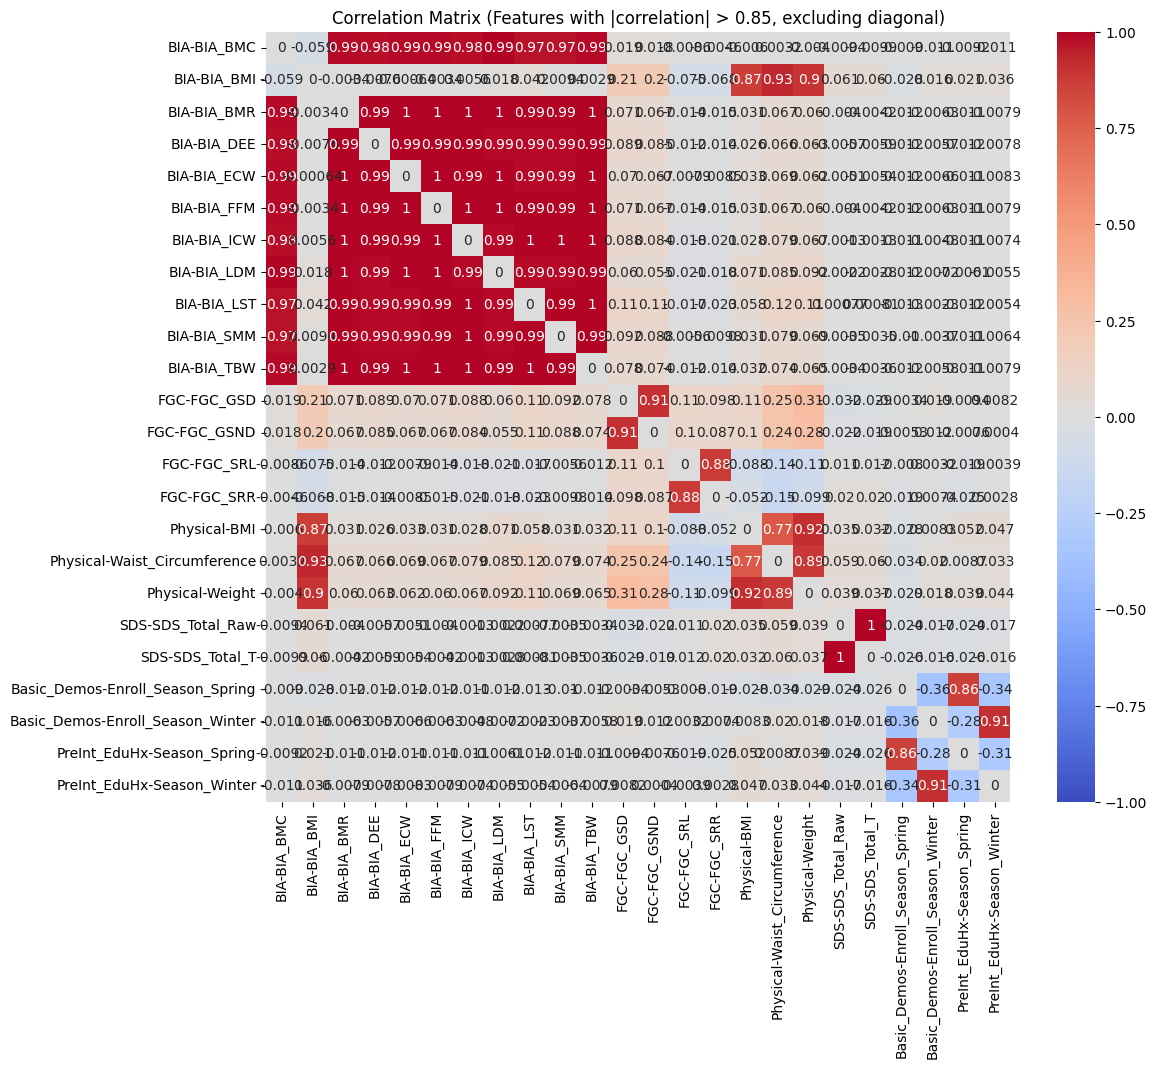

In [36]:
PrintCorrelationMatrix(X_train, 0.85)

Bia + Physical BMI provarle tutte e vedere la migliore
FGC-FGC_SRL, FGC-FGC_SRR prendere la media
togliere FGC-FGC_SRL_Zone
prendere SDS-SDS_Total_T ed escludere SDS-SDS_Total_Raw
Tutte le colonne PreInt_EduHx-Season le togliamo, sono colonne che indicano quando sono stati raccolti dati di interesse, ma di per sè sapere quando questi vengono raccolti non ce ne ciava un cazzo :)



In [12]:
def data_cleaning(df):

    # per le seguenti colonne teniamo solo BIA-BIA_FFM
    to_remove = ['BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_ICW', 
                 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']

    # Verifica se le colonne esistono nel dataframe e rimuovile
    df = df.drop(columns=[col for col in to_remove if col in df.columns])


    
    # Seleziona tutte le colonne BMI tranne 'BIA-BIA_BMI', questa sarà l'unica che terremo
    #bmi_columns = [col for col in df.columns if 'BIA' in col and col != 'BIA-BIA_BMI']
    #print(bmi_columns)
    #df = df.drop(columns=bmi_columns)
    
    # Calcola la media tra le colonne 'FGC-FGC_SRL' e 'FGC-FGC_SRR'
    if {'FGC-FGC_SRL', 'FGC-FGC_SRR'}.issubset(df.columns):
        df['FGC-FGC_SRM'] = (df['FGC-FGC_SRL'] + df['FGC-FGC_SRR']) / 2
        df = df.drop(columns=['FGC-FGC_SRL', 'FGC-FGC_SRR'])
    
    # Stessa cosa per il test
    if {'FGC-FGC_SRL', 'FGC-FGC_SRR'}.issubset(X_test.columns):
        X_test['FGC-FGC_SRM'] = (X_test['FGC-FGC_SRL'] + X_test['FGC-FGC_SRR']) / 2
    
    # Elimina colonne solo se esistono
    columns_to_drop = ['FGC-FGC_SRL_Zone', 'SDS-SDS_Total_Raw']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Elimina le colonne che iniziano con 'PreInt_EduHx-Season'
    preint_season_columns = [col for col in df.columns if 'PreInt_EduHx-Season' in col]
    df = df.drop(columns=preint_season_columns)

data = data_cleaning(data)

['BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'BIA-Season_Spring', 'BIA-Season_Summer', 'BIA-Season_Winter', 'BIA-Season_nan']


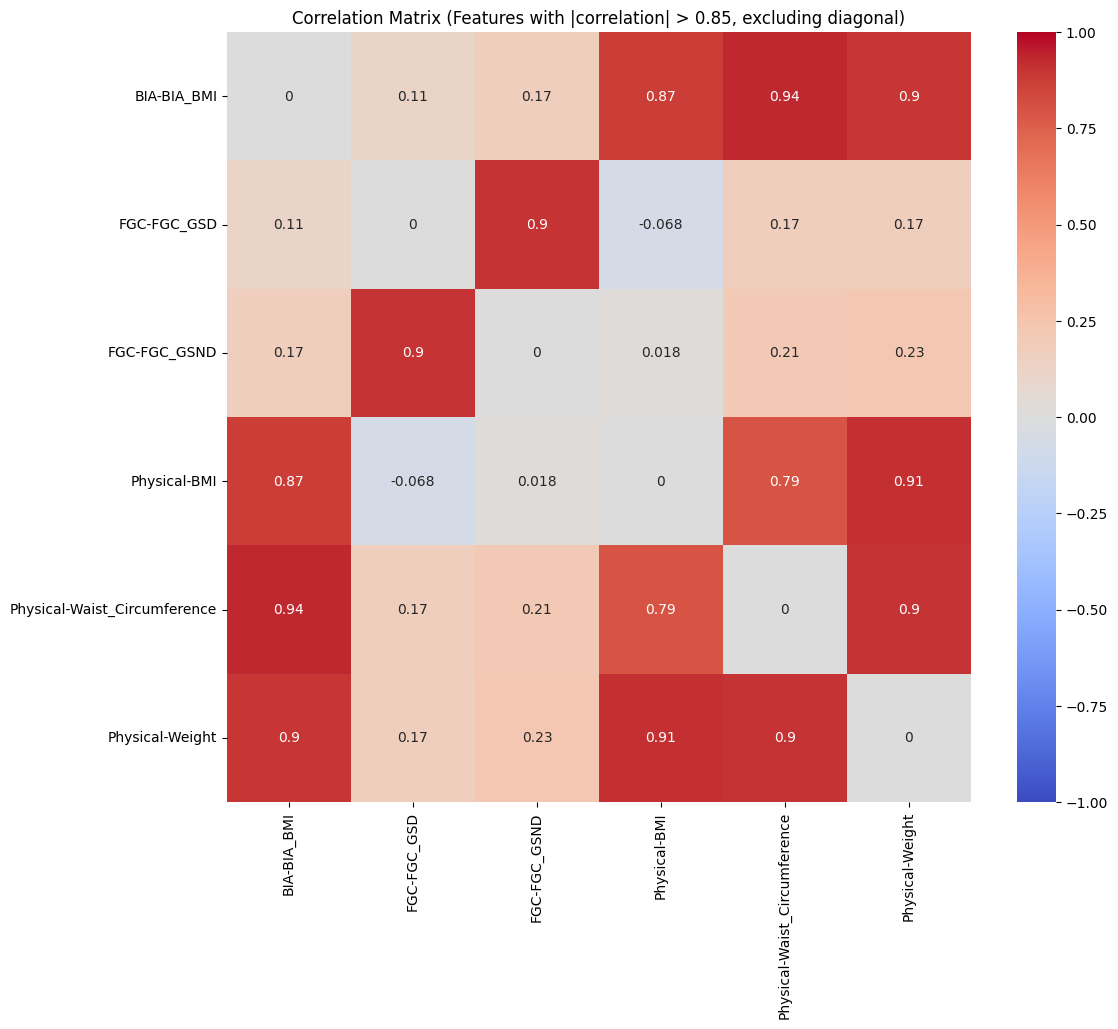

In [13]:
PrintCorrelationMatrix(X_train, 0.85)

In [14]:
# BIA-BMI è l'analisi tramite macchinario del BMI, Physical è tramite formula
to_remove = ['Physical-BMI', 'Physical-Weight', 'Physical-Waist_Circumference', 'FGC-FGC_GSD', 'FGC-FGC_GSND']

# Rimuove le colonne specificate se esistono
X_train = X_train.drop(columns=[col for col in to_remove if col in X_train.columns], errors='ignore')
print("Rimosse colonne:", ', '.join([col for col in to_remove if col in X_train.columns]) or "Nessuna colonna rimossa")

# Colonne di interesse per le zone
cols_zones = ['FGC-FGC_GSD_Zone', 'FGC-FGC_GSND_Zone']

# Calcola la media arrotondata delle zone e rimuove le colonne
if all(col in X_train.columns for col in cols_zones):
    X_train['FGC-Mean_Zone'] = X_train[cols_zones].mean(axis=1).round().astype(int)
    X_train = X_train.drop(columns=cols_zones, errors='ignore')
    print("Calcolata la media arrotondata e rimosse colonne:", ', '.join(cols_zones))
else:
    print("Una o più colonne delle zone non sono presenti")


# stessa cosa per il test
if all(col in X_test.columns for col in cols_zones):
    X_test['FGC-Mean_Zone'] = X_test[cols_zones].mean(axis=1).round().astype(int)
    print("Calcolata la media arrotondata e rimosse colonne:", ', '.join(cols_zones))
else:
    print("Una o più colonne delle zone non sono presenti")

Rimosse colonne: Nessuna colonna rimossa
Calcolata la media arrotondata e rimosse colonne: FGC-FGC_GSD_Zone, FGC-FGC_GSND_Zone
Calcolata la media arrotondata e rimosse colonne: FGC-FGC_GSD_Zone, FGC-FGC_GSND_Zone


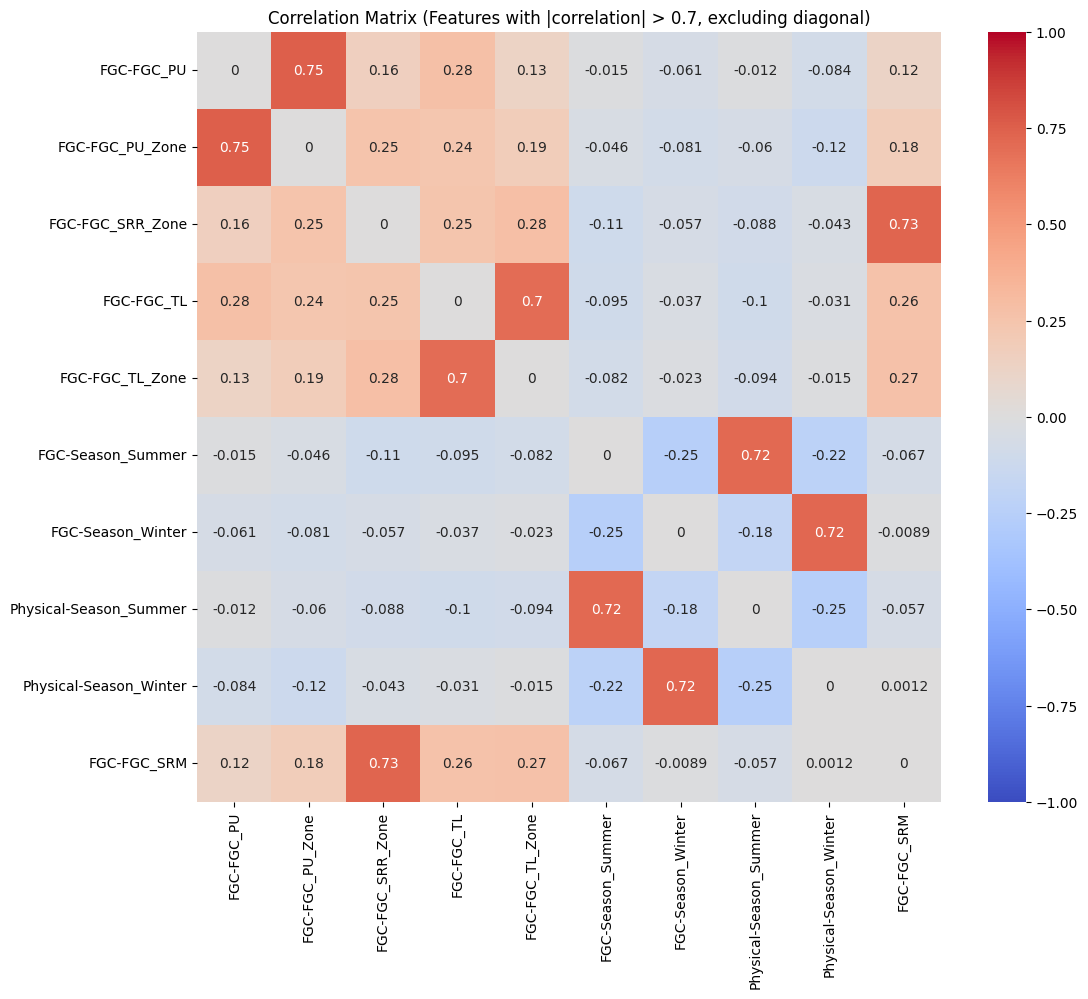

In [15]:
PrintCorrelationMatrix(X_train, 0.70)

In [16]:
# colonne come FGC-FGC_CU_Zone indicano se c'è bisogno di un miglioramento nei curl up, abbiamo già la colonna che indica quanti ne sono stati fatti
# rimuoviamole

# Definizione delle colonne da rimuovere
to_remove = ['FGC-FGC_CU_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']

# Rimozione delle colonne se esistono
to_remove_present = [col for col in to_remove if col in X_train.columns]
X_train.drop(columns=to_remove_present, inplace=True)
print(f"Rimosse colonne: {', '.join(to_remove_present)}" if to_remove_present else "Nessuna colonna da rimuovere trovata.")


Rimosse colonne: FGC-FGC_CU_Zone, FGC-FGC_PU_Zone, FGC-FGC_SRR_Zone, FGC-FGC_TL_Zone


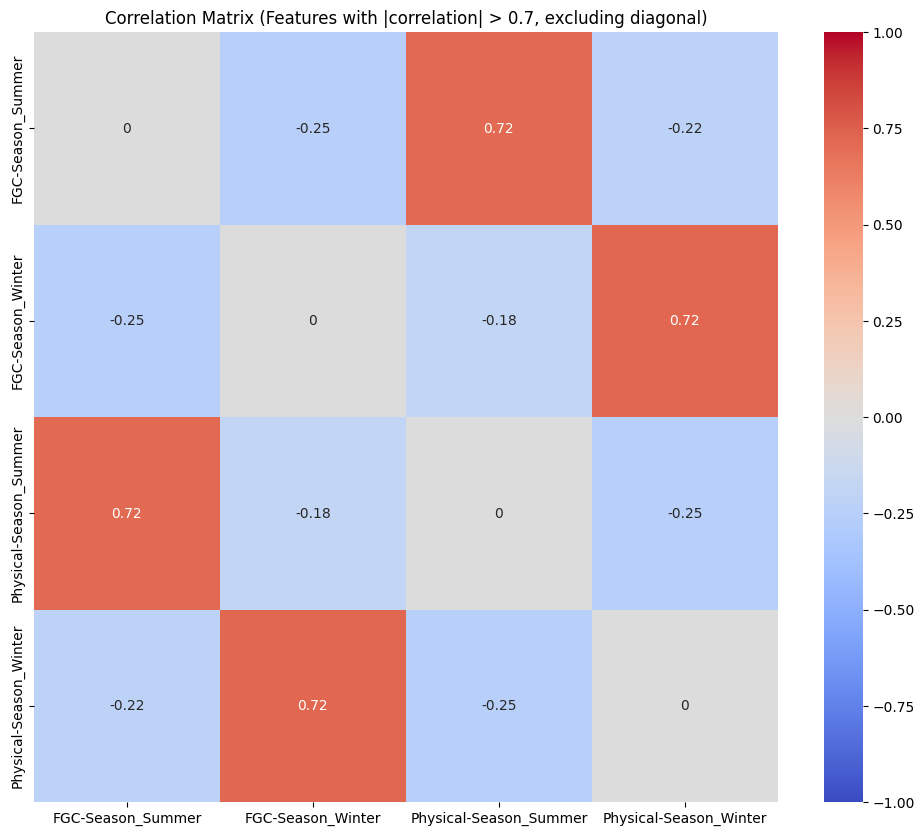

In [17]:
PrintCorrelationMatrix(X_train, 0.70)

In [18]:
# Filtriamo le colonne che contengono la parola 'Season'
season_columns = [col for col in X_train.columns if 'Season' in col]

# Stampa i nomi delle colonne che contengono 'Season'
print(season_columns)

['Basic_Demos-Enroll_Season_Spring', 'Basic_Demos-Enroll_Season_Summer', 'Basic_Demos-Enroll_Season_Winter', 'CGAS-Season_Spring', 'CGAS-Season_Summer', 'CGAS-Season_Winter', 'CGAS-Season_nan', 'FGC-Season_Spring', 'FGC-Season_Summer', 'FGC-Season_Winter', 'FGC-Season_nan', 'Fitness_Endurance-Season_Spring', 'Fitness_Endurance-Season_Summer', 'Fitness_Endurance-Season_Winter', 'Fitness_Endurance-Season_nan', 'PAQ_C-Season_Spring', 'PAQ_C-Season_Summer', 'PAQ_C-Season_Winter', 'PAQ_C-Season_nan', 'Physical-Season_Spring', 'Physical-Season_Summer', 'Physical-Season_Winter', 'Physical-Season_nan', 'SDS-Season_Spring', 'SDS-Season_Summer', 'SDS-Season_Winter', 'SDS-Season_nan']


In [19]:
# Rimuoviamo tutte le colonne season
# Filtra le colonne che contengono la parola 'Season'
season_columns = [col for col in X_train.columns if 'Season' in col]

# Rimuovi le colonne che contengono la parola 'Season'
X_train = X_train.drop(columns=season_columns)

# Stampa i nomi delle colonne rimosse
print("Colonne rimosse:")
print(season_columns)

Colonne rimosse:
['Basic_Demos-Enroll_Season_Spring', 'Basic_Demos-Enroll_Season_Summer', 'Basic_Demos-Enroll_Season_Winter', 'CGAS-Season_Spring', 'CGAS-Season_Summer', 'CGAS-Season_Winter', 'CGAS-Season_nan', 'FGC-Season_Spring', 'FGC-Season_Summer', 'FGC-Season_Winter', 'FGC-Season_nan', 'Fitness_Endurance-Season_Spring', 'Fitness_Endurance-Season_Summer', 'Fitness_Endurance-Season_Winter', 'Fitness_Endurance-Season_nan', 'PAQ_C-Season_Spring', 'PAQ_C-Season_Summer', 'PAQ_C-Season_Winter', 'PAQ_C-Season_nan', 'Physical-Season_Spring', 'Physical-Season_Summer', 'Physical-Season_Winter', 'Physical-Season_nan', 'SDS-Season_Spring', 'SDS-Season_Summer', 'SDS-Season_Winter', 'SDS-Season_nan']


/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


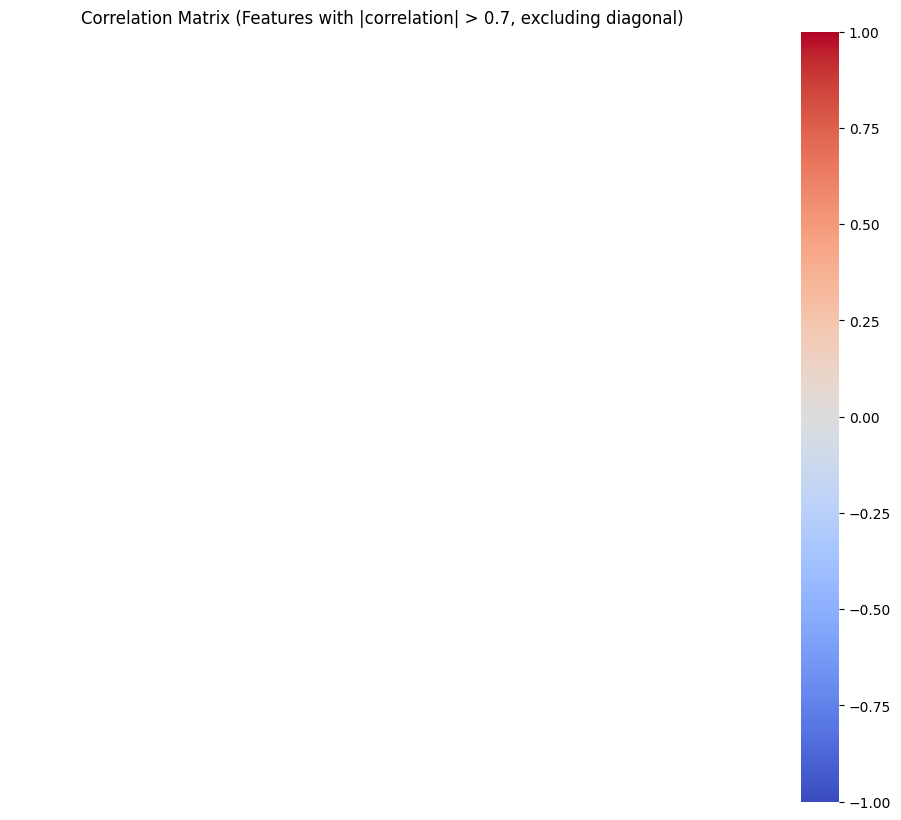

,BIA-BIA_BMI,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,FGC-FGC_CU,FGC-FGC_PU,FGC-FGC_TL,PAQ_C-PAQ_C_Total,Physical-Diastolic_BP,Physical-HeartRate,Physical-Height,Physical-Systolic_BP,PreInt_EduHx-computerinternet_hoursday,SDS-SDS_Total_T,FGC-FGC_SRM,FGC-Mean_Zone
3538,-1.373467,-1.241445,1.298200,0.283406,0.240597,0.817527,0.653307,0.868907,0.174962,-0.055423,-0.776727,0.323415,-0.667674,0.166552,0.334004,1
2411,0.600558,0.161314,-0.770297,0.202853,-0.016068,-0.077099,0.951143,-1.377488,0.834089,1.127343,0.709704,3.342467,-0.969017,0.317989,0.422936,0
1318,0.030665,1.002969,-0.770297,0.650368,0.994500,0.327580,1.588647,0.119458,-0.047686,-0.482858,2.349042,0.294104,0.857303,-0.363479,-0.584118,-1
783,-1.375956,-0.960893,-0.770297,0.068599,-0.553118,0.433149,0.469251,-0.986361,0.145570,0.661116,-0.762354,0.162204,-0.969017,-0.969229,0.331105,1
2174,-0.003636,-0.680342,-0.770297,0.874125,-0.232921,0.695717,0.815611,0.562008,1.421938,0.761388,0.359087,1.525174,-0.969017,0.317989,0.122887,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422,-1.378342,-1.241445,-0.770297,-0.244661,-0.008445,0.584734,0.447499,-0.887944,-0.246820,1.042441,-1.434483,-0.339604,0.857303,0.166552,0.361022,1
2941,-1.373467,1.844625,-0.770297,0.283406,0.240597,0.817527,0.653307,0.868907,0.174962,-0.055423,-0.776727,0.323415,-0.667674,0.166552,0.334004,1
3660,-1.370991,-1.241445,1.298200,0.193008,-0.039787,0.709251,0.686772,0.709894,0.057392,0.115844,-1.581153,0.196205,-0.969017,0.166552,0.363690,1
1368,-0.828729,-0.680342,-0.770297,-0.244661,-0.106706,-0.755175,-0.084591,-0.126220,-0.268129,-0.629240,-0.528163,-0.467987,0.857303,0.696583,-0.291994,1


In [20]:
PrintCorrelationMatrix(X_train, 0.70)
X_train

## Data preparation

In [21]:
from cleaning.rfecv_selection import rfecv_selection

column_number = rfecv_selection(X_train, y_train)
column_number

16

In [22]:
from cleaning.rfe_selection import rfe_selection

column = rfe_selection(X_train, y_train, column_number)

data = pd.concat([X_train[column], y_train], axis=1)
column

Index(['BIA-BIA_BMI', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score',
       'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_TL', 'PAQ_C-PAQ_C_Total',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Height',
       'Physical-Systolic_BP', 'PreInt_EduHx-computerinternet_hoursday',
       'SDS-SDS_Total_T', 'FGC-FGC_SRM', 'FGC-Mean_Zone'],
      dtype='object')

In [27]:
#from cleaning.gred_search_rf import grid_search_rf
from sklearn.metrics import make_scorer, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

def macro_f1_score(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=1)
    return report['macro avg']['f1-score']

def grid_search_rf(X, y):
    model = RandomForestClassifier(n_jobs=-1)

    param_grid = {
        'max_depth': [30, 40, 50, 60, 70],
        'min_samples_split': [1, 2, 3, 4, 5, 6, 7],
        'min_samples_leaf': [1, 2, 3, 5, 10]
    }

    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        scoring=make_scorer(macro_f1_score),
        cv=5
    )

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    return best_params

parameters = grid_search_rf(X_train, y_train)

parameters


Best parameters: {'max_depth': 60, 'min_samples_leaf': 1, 'min_samples_split': 7}


/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
125 fits failed out of a total of 875.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-p

{'max_depth': 60, 'min_samples_leaf': 1, 'min_samples_split': 7}

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from utils.print_confusion_matrix import print_confusion_matrix

model = RandomForestClassifier(**parameters)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test[X_train.columns])

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

n_estimators_range = range(1, 150, 10)
train_accuracies = []
test_accuracies = []

for n in n_estimators_range:
    model = RandomForestClassifier(
        max_depth=parameters['max_depth'],
        min_samples_leaf=parameters['min_samples_leaf'],
        min_samples_split=parameters['min_samples_split'],
        n_estimators=n
    )
    model.fit(X_train, y_train)
    train_accuracies.append(accuracy_score(y_train, model.predict(X_train)))
    test_accuracies.append(accuracy_score(y_test, model.predict(X_test)))

# Grafico delle accuratezze per il numero di alberi
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(n_estimators_range, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Learning Curve: Train vs Test Accuracy")
plt.legend()
plt.grid()
plt.show()

print_confusion_matrix(y_test, y_test_pred)


/home/elia/Scrivania/jupyter-docker-compose/venv/lib/python3.12/site-packages/sklearn/utils/_array_api.py:390: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_true contains NaN.

In [ ]:
X_train

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

model = models.Sequential()

hidden_layer = 1

model.add(Input(shape=(X_train.shape[1],)))

for i in range(0, hidden_layer):
    model.add(layers.Dense(16,activation='softmax'))
    model.add(Dropout(0.5))

model.add(layers.Dense(4,activation='softmax'))

model.compile( optimizer=optimizers.Adam(learning_rate=0.9),
               loss='categorical_crossentropy',       # loss function
               metrics=['acc'] )   # additional quality measure

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
class_weights = {
    0: 0.5,  # Classe 1
    1: 2.0,  # Classe 2
    2: 3.0,  # Classe 3
    3: 4.0   # Classe 4
}


# train the network
history = model.fit( x=X_train, # training examples
           y=y_train_cat, # desired output
           epochs=20,
           verbose=1,
           validation_data=(X_test, y_test_cat),
           class_weight=class_weights,
           callbacks=[lr_scheduler, early_stopping]);

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['acc'], label='Training Accuracy', color='green')
if 'val_acc' in history.history:
    plt.plot(history.history['val_acc'], label='Validation Accuracy', color='red')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predire i risultati su X_test
y_pred_prob = model.predict(X_test)  # Probabilità per ciascuna classe
y_pred = np.argmax(y_pred_prob, axis=1)  # Classe con la probabilità più alta

# Confronto con le etichette reali
y_test_original = np.argmax(y_test_cat, axis=1)  # Converti da one-hot encoding a etichette originali

# Calcolare l'accuratezza
accuracy = np.mean(y_pred == y_test_original)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

In [ ]:
# Confronto con le etichette reali
y_test_original = np.argmax(y_test_cat, axis=1)  # Converti da one-hot encoding a etichette originali

# Calcolare l'accuratezza
accuracy = np.mean(y_pred == y_test_original)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

# Mostrare alcune predizioni
for i in range(5):
    print(f"True label: {y_test_original[i]}, Predicted: {y_pred[i]}, Probabilities: {y_pred_prob[i]}")



In [ ]:
from utils.print_confusion_matrix import print_confusion_matrix


print_confusion_matrix(y_test_original, y_pred)

In [ ]:
from sklearn.model_selection import train_test_split
from itertools import product
from sklearn.metrics import classification_report

def macro_f1_score(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=1)
    return report['macro avg']['f1-score']

def evaluate_model(class_weights):
    model = models.Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(layers.Dense(16, activation='softmax'))
    model.add(Dropout(0.5))
    model.add(layers.Dense(4, activation='softmax'))

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.9),
        loss='categorical_crossentropy',
        metrics=['acc']
    )

    # Addestra il modello
    history = model.fit(
        X_train, y_train_cat,
        epochs=10,
        verbose=0,
        validation_data=(X_test, y_test_cat),
        class_weight=class_weights
    )
    
    # Calcola le probabilità e le etichette predette
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_test_original = np.argmax(y_test_cat, axis=1)
   
    # Genera il classification report con macro average
    report = classification_report(y_test_original, y_pred, output_dict=True, zero_division=1)
    
    # Ottieni il f1-score macro direttamente dal classification_report
    macro_f1 = report['macro avg']['f1-score']
    
    return macro_f1


class_weights_values = {
    0: [0.7, 0.8, 0.85, 0.9, 1],
    1: [1, 1.2, 1.4, 1.5, 1.6, 1.8],
    2: [1.7, 1, 1.2, 1.5],
    3: [1.2, 1.4, 1.5, 1.6, 1.8]
}

param_grid = [dict(zip(class_weights_values.keys(), comb)) for comb in product(*class_weights_values.values())]

# Esegui la ricerca a griglia manuale
best_score = 0
best_params = None

print("start training...")
for weights in param_grid:
    score = evaluate_model(weights)
    print(f"Pesi: {weights} - Macro: {score:.4f}")
    if score > best_score:
        best_score = score
        best_params = weights

print(f"Migliore f1-pesato: {best_score:.4f} con pesi: {best_params}")

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

model = models.Sequential()

hidden_layer = 1

model.add(Input(shape=(X_train.shape[1],)))

for i in range(0, hidden_layer):
    model.add(layers.Dense(16,activation='softmax'))
    model.add(Dropout(0.5))

model.add(layers.Dense(4,activation='softmax'))

model.compile( optimizer=optimizers.Adam(learning_rate=0.9),
               loss='categorical_crossentropy',       # loss function
               metrics=['acc'] )   # additional quality measure

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

print(f" weight: {best_params}")
# train the network
history = model.fit( x=X_train, # training examples
           y=y_train_cat, # desired output
           epochs=15,
           verbose=1,
           validation_data=(X_test, y_test_cat),
           class_weight= best_params,
           callbacks=[lr_scheduler, early_stopping]);

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['acc'], label='Training Accuracy', color='green')
if 'val_acc' in history.history:
    plt.plot(history.history['val_acc'], label='Validation Accuracy', color='red')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predire i risultati su X_test
y_pred_prob = model.predict(X_test)  # Probabilità per ciascuna classe
y_pred = np.argmax(y_pred_prob, axis=1)  # Classe con la probabilità più alta

# Confronto con le etichette reali
y_test_original = np.argmax(y_test_cat, axis=1)  # Converti da one-hot encoding a etichette originali

# Calcolare l'accuratezza
accuracy = np.mean(y_pred == y_test_original)
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

print(f"Unweight accuracy: {classification_report(y_test_original, y_pred, output_dict=True, zero_division=1)['macro avg']['f1-score']}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcolare la matrice di confusione
conf_matrix = confusion_matrix(y_test_original, y_pred)

# Visualizzare la matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(4))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
